# Yol Ayarı
Notebook’tan src/ ve scripts/ modüllerini görebilmemiz için yol ekliyoruz. Kod değişince otomatik yeniden yüklensin.

In [11]:
# 0) Proje kökünü import yoluna ekle ve autoreload aç
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))  # <-- SADE VE YETER

%load_ext autoreload
%autoreload 2

# Basit doğrulama:
import scripts, src
print("roots ok:", scripts.__file__, "|", src.__file__)


roots ok: None | None


# İndir -> Hazırla -> Eğit
Kaggle’dan veriyi indirir, temizleyip train/test ayırır, ölçekleyip scaler’ı kaydeder, modeli eğitir ve metrikleri yazar.

In [12]:
from scripts.pipeline import run_download, run_prepare, run_train, load_processed, load_metrics
# sıralı akış
run_download()
run_prepare()
run_train()

# çıktıları elde tut
train_df, test_df = load_processed()
metrics = load_metrics()
print("Metrikler:", metrics)
train_df.head(3), test_df.head(3)

c:\Users\Burak Alp Arslan\Desktop\DataScience\LR_LungVolume\.venv_lr312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[download] 396 satır ve 5 sütun ile veri indirildi -> C:\Users\Burak Alp Arslan\Desktop\DataScience\LR_LungVolume\data\raw\data.csv
[prepare] Gereksiz sütunlar kaldırıldı: ['Unnamed: 0']
[prepare] Eksik veriler kaldırıldı: 0 satır silindi
[prepare] Sayısal özellikler 'standard' ile ölçeklendirildi: ['age', 'height']
[prepare] Ölçekleyici kaydedildi: C:\Users\Burak Alp Arslan\Desktop\DataScience\LR_LungVolume\models\scaler.pkl
[prepare] Eğitim seti kaydedildi: 316 satır -> C:\Users\Burak Alp Arslan\Desktop\DataScience\LR_LungVolume\data\processed\train.csv
[prepare] Test seti kaydedildi: 80 satır -> C:\Users\Burak Alp Arslan\Desktop\DataScience\LR_LungVolume\data\processed\test.csv

[train] Model eğitimi tamamlandı.
[train] Model : C:\Users\Burak Alp Arslan\Desktop\DataScience\LR_LungVolume\models\lr_model.pkl
[train] Metrik : C:\Users\Burak Alp Arslan\Desktop\DataScience\LR_LungVolume\reports\metrics.json -> {'MAE': 0.19644422656628496, 'MSE': 0.055486826625576566, 'R2': 0.924473346783

(        age    height  sex     IC
 0  0.166092 -0.268359    1  3.042
 1 -0.625139  0.774306    0  2.963
 2  1.590306  0.302559    0  2.458,
         age    height  sex     IC
 0 -1.099877  0.697326    1  3.070
 1 -1.416369 -1.175189    1  1.740
 2  1.379312 -0.228942    0  2.304)

# Keşif özeti (EDA): şekil, dtype, eksik raporu
Verinin yapısını, sayısal özetini ve eksik değerleri hızlıca görmemizi sağlar.

In [17]:
from scripts.explore import info_summary, missing_report, describe_numeric
from scripts.visualize import plot_histograms, plot_corr_heatmap

info = info_summary(train_df)
desc = describe_numeric(train_df)
miss = missing_report(train_df)

print("info:", info)
display(desc)
display(miss if not miss.empty else "Eksik değer yok")


info: {'shape': (316, 4), 'dtypes': {'age': 'float64', 'height': 'float64', 'sex': 'int64', 'IC': 'float64'}}


,count,mean,std,min,25%,50%,75%,max
age,316.0,-3.372829e-17,1.001586,-1.732861,-0.849321,0.034220,0.865012,1.695804
height,316.0,-5.312206e-16,1.001586,-3.202620,-0.361160,-0.014392,0.631547,1.756201
sex,316.0,5.031646e-01,0.500783,0.000000,0.000000,1.000000,1.000000,1.000000
IC,316.0,2.772750e+00,0.840574,0.780000,2.259000,2.798500,3.210000,4.528000


'Eksik değer yok'

# Histogramlar (age, height)
Numerik kolonların dağılımlarını görselleştiriyoruz.

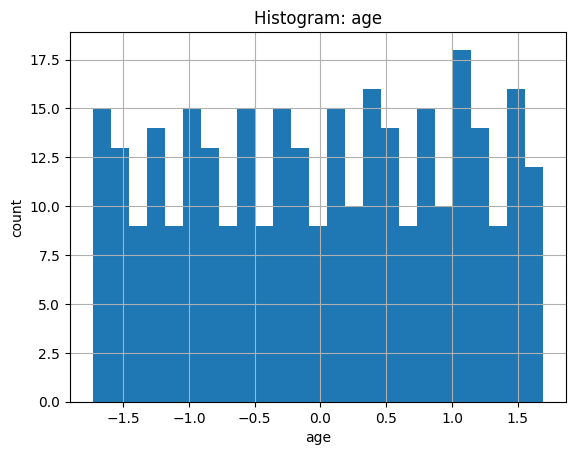

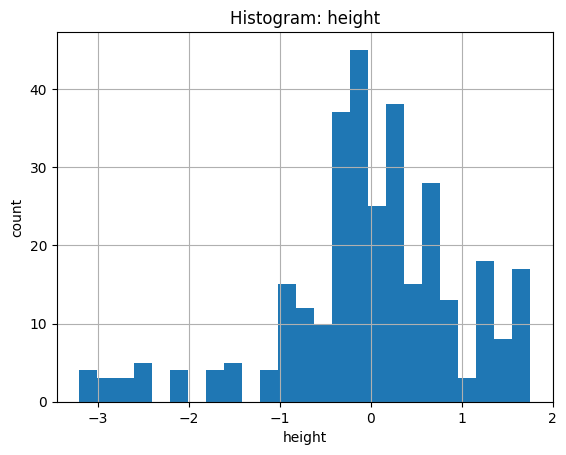

In [18]:
from scripts.visualize import plot_histograms, plot_corr_heatmap, plot_actual_vs_pred
plot_histograms(train_df, cols=["age", "height"], bins=25)


# Korelasyon ısı haritası
Sayısal kolonlar arasındaki ilişkilere hızlı bakış.

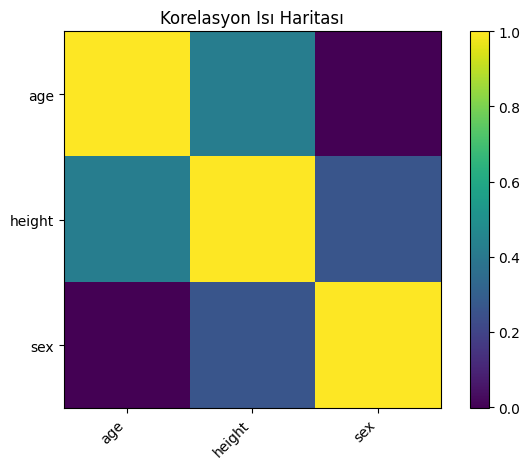

In [19]:
plot_corr_heatmap(train_df, cols=["age", "height", "sex"])

# Gerçek vs Tahmin (test seti)
Modelin test verisindeki performansını görsel olarak kontrol et (mükemmel uyum çizgisiyle).

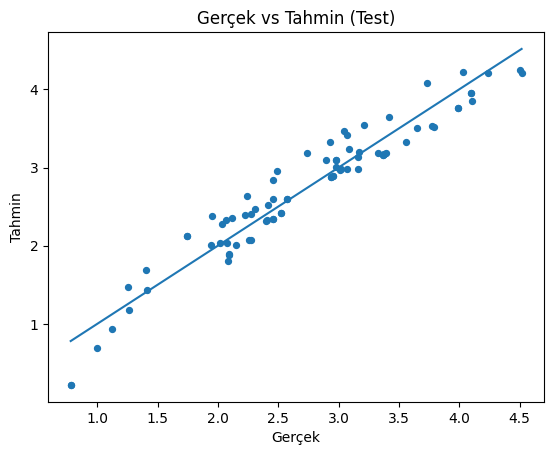

In [21]:
import pandas as pd
from src import config as cfg
from joblib import load

model = load(cfg.MODEL_PATH)
X_cols = cfg.FEATURES_NUM + cfg.FEATURES_CAT
test_df = pd.read_csv(cfg.TEST_DATA)

y_true = test_df[cfg.TARGET].to_numpy()
y_pred = model.predict(test_df[X_cols])

plot_actual_vs_pred(y_true, y_pred, title="Gerçek vs Tahmin (Test)")


# Katsayı tablosu (yorum için)
Linear Regression katsayılarını büyüklüğe göre sırala; hangi özellik daha etkili görünüyor?

In [22]:
import pandas as pd
from joblib import load

model = load(cfg.MODEL_PATH)
X_cols = cfg.FEATURES_NUM + cfg.FEATURES_CAT

coef_df = pd.Series(model.coef_, index=X_cols, name="coef").to_frame().sort_values("coef", ascending=False)
display(coef_df)
print("intercept:", float(model.intercept_))


,coef
height,0.675417
sex,0.515413
age,0.075995


intercept: 2.5134126465396784


# Hızlı tekil tahmin (quick_predict)
Tek satır girdiyle (M/F veya 1/0) hızlı tahmin al.

In [26]:
from scripts.predict_tools import quick_predict, batch_predict, load_model_and_scaler
quick_predict(age=24, height=178, sex="M")
print("24 yaşında 178 boyunda bir erkeğin akciğer kapasitesi yaklaşık\n",
      quick_predict(age=24, height=178, sex="M"),"Litredir.")

24 yaşında 178 boyunda bir erkeğin akciğer kapasitesi yaklaşık
 3.5533637316811575 Litredir.


# Toplu tahmin (batch_predict)
Birden fazla kaydı tek seferde tahmin et; sonuç serisini gör.

In [32]:
batch_predict([
    {"age": 30, "height": 170, "sex": "F"},
    {"age": 55, "height": 182, "sex": "F"},
    {"age": 43, "height": 165, "sex": "M"},
])


0    2.738812
1    3.323815
2    3.104342
Name: prediction, dtype: float64